### Objective

깃헙은 온갖 유저와 코드 리파짓토리들이 모여있습니다. 유저는 리파짓토리에 코드를 올리기도, 가져오기도, 리파짓토리에 이슈를 제기하기도, 리파짓토리를 복제해오기도 합니다. 10가지가 넘는 action이 나뉘어져 있고, 이런 action들을 통해 우리는 유저와 리파짓토리의 특성을 파악해 볼 수 있습니다.

#### github 내 액션들

| 액션   | 설명 |
| :----     | :----      |
|PushEvent| One or more commits are pushed to a repository branch or tag. |
|CreateEvent| A Git branch or tag is created. For more information, see the "Git data" REST API. |
|WatchEvent| When someone stars a repository |
|IssueCommentEvent| Activity related to an issue comment |
|IssuesEvent| Activity related to an issue |
|PullRequestEvent| Activity related to pull requests. |
|ForkEvent| A user forks a repository |
|DeleteEvent| A Git branch or tag is deleted |
|PullRequestReviewCommentEvent| Activity related to pull request review comments in the pull request's unified diff |
|GollumEvent| A wiki page is created or updated |
|CommitCommentEvent| A commit comment is created |
|MemberEvent| Activity related to repository collaborators |
|ReleaseEvent| Activity related to a release |

### Load Packages

In [2]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.cloud import bigquery

# setup credentials
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = (
    os.path.abspath("../credentials/github-bigquery.json"))

In [3]:
%load_ext google.cloud.bigquery

## Exploratory Data Analysis

### Q.1 ) 얼마나 많은 리파짓토리와 유저가 존재할까요? 

#### 유저의 수 

2,400만명 가량이 2012년부터 지금까지 활동하였습니다. 

reference : [APPROX_COUNT_DISTINCT](https://cloud.google.com/bigquery/docs/reference/standard-sql/approximate_aggregate_functions)

In [4]:
%%bigquery

SELECT 
    APPROX_COUNT_DISTINCT(actor.id) as actor_count
FROM
    `githubarchive.year.*`

,actor_count
0,24039006


#### 리파짓토리의 수 

1.3억개의 public repository가 존재합니다. 평균 유저 당 5~6개 정도를 만들고 있다고 볼 수 있습니다. 

In [5]:
%%bigquery

SELECT 
    APPROX_COUNT_DISTINCT(repo.id) as repo_count
FROM
    `githubarchive.year.*`

,repo_count
0,131294070


### Q.2) 한사람이 얼마나 많은 리파짓토리에 관여할까요?

2400만명이 존재하므로, 샘플링하여 보도록 하겠습니다. 

In [6]:
%%bigquery actor_df

SELECT
    actor.id as actor_id,
    APPROX_COUNT_DISTINCT(repo.id) as num_repo
FROM
    `githubarchive.year.*`
WHERE 
    repo.id IS NOT NULL
GROUP BY
    actor.id
HAVING
    RAND() < 0.01

#### 분위수로 확인해보기

In [229]:
(
    actor_df
    .num_repo
    .quantile(q=[0.5, 0.8, 0.9, 0.99])
)

0.50      2.0
0.80     10.0
0.90     24.0
0.99    194.0
Name: num_repo, dtype: float64

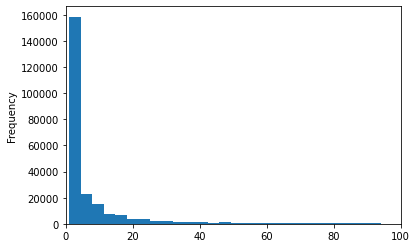

In [224]:
(
    actor_df
    .num_repo
    .plot(kind='hist', 
          bins=10000,
          xlim=(0,100))
)

### Q.3) 하나의 리파짓토리에는 얼마나 많은 유저들이 관여할까요? 

1.3억개의 public repository가 존재하므로, 샘플링하여 보도록 하겠습니다.

In [7]:
%%bigquery repo_df

SELECT
    repo.id as repo_id,
    APPROX_COUNT_DISTINCT(actor.id) as num_actor
FROM
    `githubarchive.year.*`
WHERE 
    repo.id IS NOT NULL
GROUP BY
    repo.id
HAVING
    RAND() < 0.01

#### 분위수로 확인해보기

대부분 리파짓토리는 혼자 관리되고 있습니다. 

In [8]:
(
    repo_df
    .num_actor
    .quantile(q=[0.5, 0.8, 0.9, 0.99])
)

0.50     1.0
0.80     1.0
0.90     2.0
0.99    12.0
Name: num_actor, dtype: float64

### Q.4) 하나의 리파짓토리에는 보통 얼마만큼의 활동 기록이 쌓여있을까요?

대부분의 레파짓토리는 20번 이하의 활동 기록을 보여주고 있습니다. 상위 5%의 레파짓토리만이 39번 을 기록하고 있습니다.

In [235]:
%%bigquery quantile_df

SELECT 
    APPROX_QUANTILES(repo_counts, 1000) as quantile
FROM (
    SELECT COUNT(repo.id) as repo_counts
    FROM `githubarchive.year.*`    
    GROUP BY repo.id
)

In [236]:
qlist = quantile_df.values[0][0]
print("50.0% quantile :", qlist[500])
print("90.0% quantile :", qlist[900])
print("95.0% quantile :", qlist[950])
print("98.0% quantile :", qlist[980])
print("99.0% quantile :", qlist[990])
print("99.5% quantile :", qlist[995])
print("99.8% quantile :", qlist[998])
print("99.9% quantile :", qlist[999])

50.0% quantile : 3
90.0% quantile : 20
95.0% quantile : 39
98.0% quantile : 93
99.0% quantile : 169
99.5% quantile : 304
99.8% quantile : 666
99.9% quantile : 1199


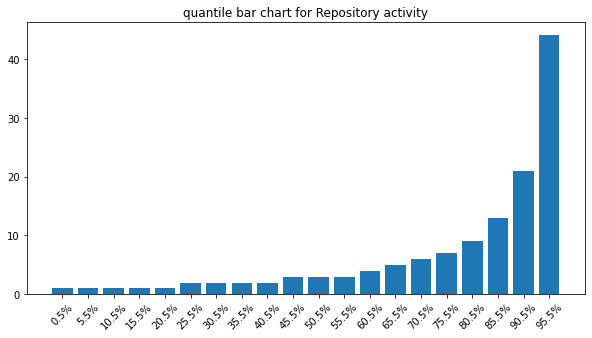

In [92]:
xs = [f"{i/1000:.1%}" for i in range(1001)]
fig = plt.figure(figsize=(10,5))

plt.title("quantile bar chart for Repository activity")
plt.bar(xs[5:-1:50], qlist[5:-1:50])
plt.xticks(rotation=45)
plt.show()

### Q.5) 활동 기록 중에서 action들은 각각 얼마만큼 차지하고 있을까요? 

PIE Chart로 시각화해보도록 하겠습니다. 가장 많이 차지하는 활동은 코드를 리파짓토리에 저장하는 PushEvent와 리파짓토리를 생성하는 CreateEvent입니다. 

In [237]:
%%bigquery action_df

(
    SELECT 
        type as action, COUNT(*) as count
    FROM 
        `githubarchive.year.*`
    GROUP BY 
        type
)

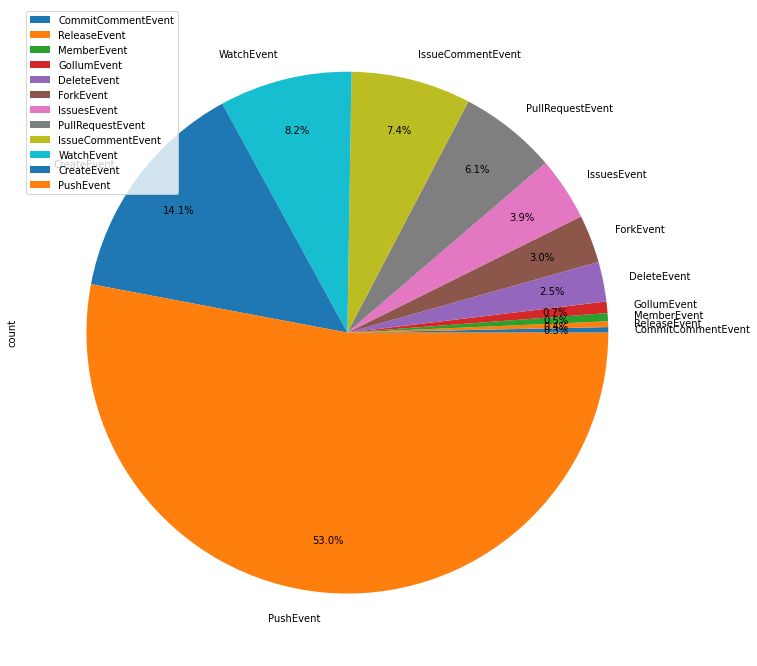

In [264]:
actions_list = [
    'WatchEvent', 'PushEvent', 'PullRequestEvent', 
    'IssueCommentEvent', 'ForkEvent', 'CreateEvent', 
    'IssuesEvent', 'DeleteEvent', 'CommitCommentEvent', 
    'ReleaseEvent', 'GollumEvent', 'MemberEvent']

(
    action_df
    .set_index('action')
    .loc[actions_list]
    .sort_values(by='count')
    .plot(y='count',kind='pie',
          autopct='%1.1f%%',
          pctdistance=0.8,
          figsize=(15, 12))
)
plt.show()

### Q.6) 각 리파짓토리 별로 action의 비율이 어떻게 될까요?

코드를 꾸준히 업데이트하는 open source framework 같은 리파짓토리가 있고, 코딩 인터뷰 문제 모음집과 같이 사람들이 많이 watch하는 리파짓토리가 존재합니다. 리파짓토리 action의 비율을 보면, 리파짓토리의 속성을 어느정도 유추할 수 있습니다.

이를 분석하기 위해, repository는 row로, action type은 column으로 pivot하여 분석하겠습니다. pivot code는 아래를 참고했습니다.

reference : [build pivot tables in bigquery ](https://corecompete.com/how-to-build-pivot-tables-in-bigquery-fast-and-easy/)

In [60]:
%%bigquery pivot_repo_df

WITH
    source_table AS (
        SELECT 
            repo.id as id, 
            ANY_VALUE(repo.name) as name,
            ANY_VALUE(repo.url) as url,
            type as class, 
            COUNT(repo.id) as values
        FROM 
            `githubarchive.year.*`
        WHERE 
            repo.id in (
                SELECT
                    repo.id,
                FROM 
                    `githubarchive.year.*`        
                GROUP BY 
                    id
                HAVING 
                    COUNT(DISTINCT actor.id) > 10)
        GROUP BY 
            id, class),
    
    wide_rank AS (
        SELECT 
            ANY_VALUE(IF(class='WatchEvent', rank, null)) as WatchEvent,
            ANY_VALUE(IF(class='PushEvent', rank, null)) as PushEvent,
            ANY_VALUE(IF(class='PullRequestEvent', rank, null)) as PullRequestEvent,
            ANY_VALUE(IF(class='IssueCommentEvent', rank, null)) as IssueCommentEvent,
            ANY_VALUE(IF(class='ForkEvent', rank, null)) as ForkEvent,
            ANY_VALUE(IF(class='CreateEvent', rank, null)) as CreateEvent,
            ANY_VALUE(IF(class='IssuesEvent', rank, null)) as IssuesEvent,
            ANY_VALUE(IF(class='DeleteEvent', rank, null)) as DeleteEvent,
            ANY_VALUE(IF(class='CommitCommentEvent', rank, null)) as CommitCommentEvent,
            ANY_VALUE(IF(class='ReleaseEvent', rank, null)) as ReleaseEvent,
            ANY_VALUE(IF(class='GollumEvent', rank, null)) as GollumEvent,
            ANY_VALUE(IF(class='MemberEvent', rank, null)) as MemberEvent
        FROM (
            SELECT 
                "1" as groupby_only_col, 
                class, 
                RANK() over (ORDER BY class) AS rank
            FROM (
                SELECT DISTINCT class
                FROM source_table
            )
        )
        GROUP BY groupby_only_col),

    long_array_aggregated AS (
        SELECT 
            id,
            ARRAY_AGG(values ORDER BY rank) as agg_values
        FROM (
            SELECT 
                ranked_classes_by_id.id as id,
                ranked_classes_by_id.rank as rank,
                source_table.values as values
            FROM source_table
            RIGHT JOIN (
                SELECT 
                    id,
                    class,
                    rank() over (PARTITION BY id ORDER BY class)  as rank
                FROM (
                    SELECT 
                        DISTINCT class
                    FROM
                        source_table)
                    CROSS JOIN ( SELECT DISTINCT id FROM source_table)
                ) as ranked_classes_by_id
            USING(id, class)
            )
        GROUP BY id)

SELECT 
    A.id,
    A.agg_values[ordinal(WatchEvent)] as WatchEvent,
    A.agg_values[ordinal(PushEvent)] as PushEvent,
    A.agg_values[ordinal(PullRequestEvent)] as PullRequestEvent,
    A.agg_values[ordinal(IssueCommentEvent)] as IssueCommentEvent,
    A.agg_values[ordinal(ForkEvent)] as ForkEvent,
    A.agg_values[ordinal(CreateEvent)] as CreateEvent,
    A.agg_values[ordinal(IssuesEvent)] as IssuesEvent,
    A.agg_values[ordinal(DeleteEvent)] as DeleteEvent,
    A.agg_values[ordinal(CommitCommentEvent)] as CommitCommentEvent,
    A.agg_values[ordinal(ReleaseEvent)] as ReleaseEvent,
    A.agg_values[ordinal(GollumEvent)] as GollumEvent,
    A.agg_values[ordinal(MemberEvent)] as MemberEvent,

FROM 
    long_array_aggregated A, 
    wide_rank B

In [63]:
log_repo_df = (
    pivot_repo_df
    .set_index('id')
    .fillna(0)
    .astype(np.int)
    .apply(lambda x : np.log10(1+x))
)

In [64]:
def visualize_scatter(x, y):
    # reference : https://jakevdp.github.io/PythonDataScienceHandbook/04.08-multiple-subplots.html
    fig = plt.figure(figsize=(6, 6))
    grid = plt.GridSpec(4, 4, hspace=0.2, wspace=0.2)
    main_ax = fig.add_subplot(grid[:-1, 1:])
    y_hist = fig.add_subplot(grid[:-1, 0], xticklabels=[], sharey=main_ax)
    x_hist = fig.add_subplot(grid[-1, 1:], yticklabels=[], sharex=main_ax)

    # scatter points on the main axes
    main_ax.plot(x, y, 'x', markersize=3, alpha=0.2)

    # histogram on the attached axes
    x_hist.hist(x, 40, histtype='stepfilled', orientation='vertical')
    x_hist.invert_yaxis()

    y_hist.hist(y, 40, histtype='stepfilled', orientation='horizontal')
    y_hist.invert_xaxis()    
    plt.show()

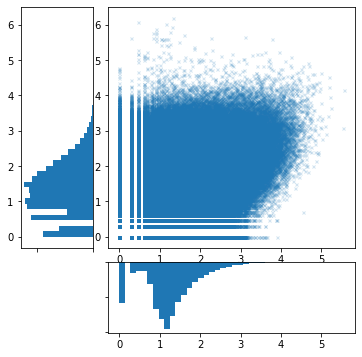

In [65]:
visualize_scatter(log_repo_df.WatchEvent, log_repo_df.PushEvent)

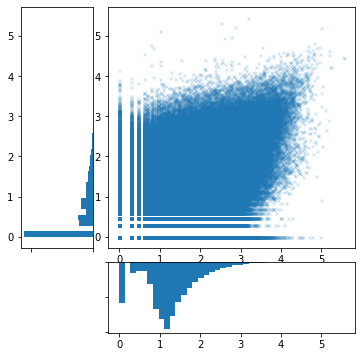

In [66]:
visualize_scatter(log_repo_df.WatchEvent, log_repo_df.IssuesEvent)

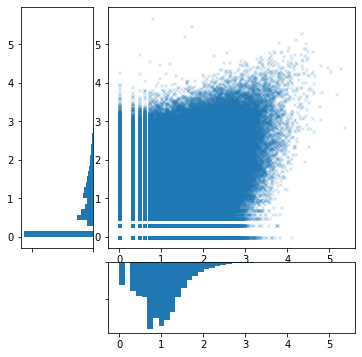

In [67]:
visualize_scatter(log_repo_df.ForkEvent, log_repo_df.PullRequestEvent)

### Q.7) 각 리파짓토리/ 활동 별로 얼마나 다양한 사람이 활동하고 있을까요?

깃헙은 플랫폼이고 하나의 네트워크입니다. 네트워크에서 중요도는 얼마나 **다양한** 유저와 관계를 맺고 있는가로 평가할 수 있습니다. 아까와 달리, 유저의 수를 기준으로 pivot 해보도록 하겠습니다.

In [9]:
%%bigquery pivot_actor_df

WITH
    source_table AS (
        SELECT 
            repo.id as id, 
            ANY_VALUE(repo.name) as name,
            ANY_VALUE(repo.url) as url,
            type as class, 
            COUNT(DISTINCT actor.id) as values
        FROM 
            `githubarchive.year.*`
        WHERE 
            repo.id in (
                SELECT
                    repo.id,
                FROM 
                    `githubarchive.year.*`        
                GROUP BY 
                    id
                HAVING 
                    COUNT(DISTINCT actor.id) > 10)
        GROUP BY 
            id, class),
    
    wide_rank AS (
        SELECT 
            ANY_VALUE(IF(class='WatchEvent', rank, null)) as WatchEvent,
            ANY_VALUE(IF(class='PushEvent', rank, null)) as PushEvent,
            ANY_VALUE(IF(class='PullRequestEvent', rank, null)) as PullRequestEvent,
            ANY_VALUE(IF(class='IssueCommentEvent', rank, null)) as IssueCommentEvent,
            ANY_VALUE(IF(class='ForkEvent', rank, null)) as ForkEvent,
            ANY_VALUE(IF(class='CreateEvent', rank, null)) as CreateEvent,
            ANY_VALUE(IF(class='IssuesEvent', rank, null)) as IssuesEvent,
            ANY_VALUE(IF(class='DeleteEvent', rank, null)) as DeleteEvent,
            ANY_VALUE(IF(class='CommitCommentEvent', rank, null)) as CommitCommentEvent,
            ANY_VALUE(IF(class='ReleaseEvent', rank, null)) as ReleaseEvent,
            ANY_VALUE(IF(class='GollumEvent', rank, null)) as GollumEvent,
            ANY_VALUE(IF(class='MemberEvent', rank, null)) as MemberEvent
        FROM (
            SELECT 
                "1" as groupby_only_col, 
                class, 
                RANK() over (ORDER BY class) AS rank
            FROM (
                SELECT DISTINCT class
                FROM source_table
            )
        )
        GROUP BY groupby_only_col),

    long_array_aggregated AS (
        SELECT 
            id,
            ARRAY_AGG(values ORDER BY rank) as agg_values
        FROM (
            SELECT 
                ranked_classes_by_id.id as id,
                ranked_classes_by_id.rank as rank,
                source_table.values as values
            FROM source_table
            RIGHT JOIN (
                SELECT 
                    id,
                    class,
                    rank() over (PARTITION BY id ORDER BY class)  as rank
                FROM (
                    SELECT 
                        DISTINCT class
                    FROM
                        source_table)
                    CROSS JOIN ( SELECT DISTINCT id FROM source_table)
                ) as ranked_classes_by_id
            USING(id, class)
            )
        GROUP BY id)

SELECT 
    A.id,
    A.agg_values[ordinal(WatchEvent)] as WatchEvent,
    A.agg_values[ordinal(PushEvent)] as PushEvent,
    A.agg_values[ordinal(PullRequestEvent)] as PullRequestEvent,
    A.agg_values[ordinal(IssueCommentEvent)] as IssueCommentEvent,
    A.agg_values[ordinal(ForkEvent)] as ForkEvent,
    A.agg_values[ordinal(CreateEvent)] as CreateEvent,
    A.agg_values[ordinal(IssuesEvent)] as IssuesEvent,
    A.agg_values[ordinal(DeleteEvent)] as DeleteEvent,
    A.agg_values[ordinal(CommitCommentEvent)] as CommitCommentEvent,
    A.agg_values[ordinal(ReleaseEvent)] as ReleaseEvent,
    A.agg_values[ordinal(GollumEvent)] as GollumEvent,
    A.agg_values[ordinal(MemberEvent)] as MemberEvent,

FROM 
    long_array_aggregated A, 
    wide_rank B

In [ ]:
log_actor_df = (
    pivot_actor_df
    .set_index('id')
    .fillna(0)
    .astype(np.int)
    .apply(lambda x : np.log10(1+x))
)

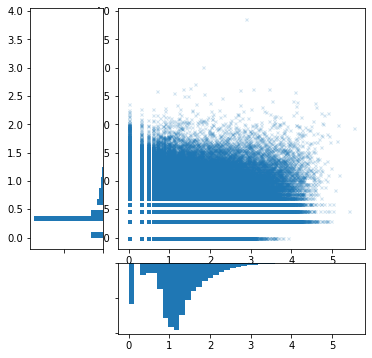

In [57]:
visualize_scatter(log_actor_df.WatchEvent, log_actor_df.PushEvent)

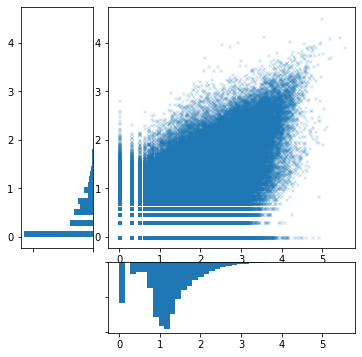

In [58]:
visualize_scatter(log_actor_df.WatchEvent, log_actor_df.IssuesEvent)

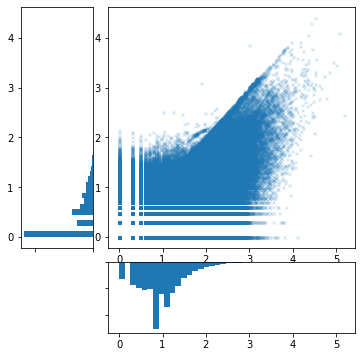

In [59]:
visualize_scatter(log_actor_df.ForkEvent, log_actor_df.PullRequestEvent)